In [1]:
from fastai.vision.all import *
import torchvision
import torchvision.transforms as transforms
from livelossplot import PlotLosses

URLs.MNIST

'https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz'

In [2]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('testing'),Path('training')]

In [3]:
(path / 'training').ls()

(#10) [Path('training/0'),Path('training/1'),Path('training/2'),Path('training/3'),Path('training/4'),Path('training/5'),Path('training/6'),Path('training/7'),Path('training/8'),Path('training/9')]

In [4]:
test_image = Image.open((path/"training/1").ls()[0])
print(test_image.size)
test_image

(28, 28)


In [5]:
transform = transforms.Compose(
    [transforms.Grayscale(), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
)

In [6]:
full_dataset = torchvision.datasets.ImageFolder((path/"training").as_posix(), transform = transform)

train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
training_set, validation_set = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

testing_set = torchvision.datasets.ImageFolder((path/"testing").as_posix(), transform = transform)

In [7]:
bs = 64

train_loader = torch.utils.data.DataLoader(training_set, batch_size=bs, shuffle=True, num_workers = 12)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=bs, num_workers = 4)
dataloaders = {
    "train": train_loader,
    "validation": validation_loader
}

In [8]:
pytorch_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 50),
    nn.ReLU(),
    nn.Linear(50,10),
    nn.LogSoftmax(dim=1))

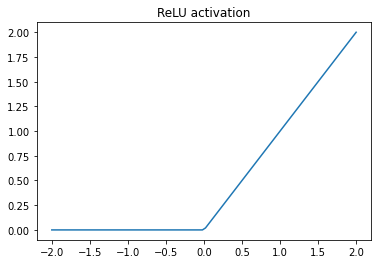

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lr = 1e-2
nb_epoch = 30

In [10]:
optimizer = torch.optim.SGD(pytorch_net.parameters(), lr=lr)

In [11]:
criterion = nn.NLLLoss()

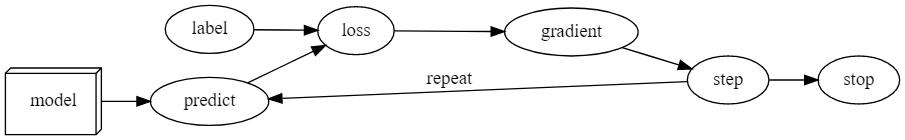

In [12]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']: # First train, then validate
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0 # keep track of loss
            running_corrects = 0 # count of correctly classified inputs

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad() # Set all previously calculated gradients to 0
                    loss.backward() # Calculate gradients
                    optimizer.step() # Step on the weights using those gradient w -=  gradient(w) * lr
                
                # the output is of shape (n_batches, 10)
                _, preds = torch.max(outputs, 1)
                
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset) # get the "mean" loss for the epoch
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset) # Get proportion of correct predictions
            
            # Logging
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs) # Update logs
        liveloss.send() # draw, display stuff

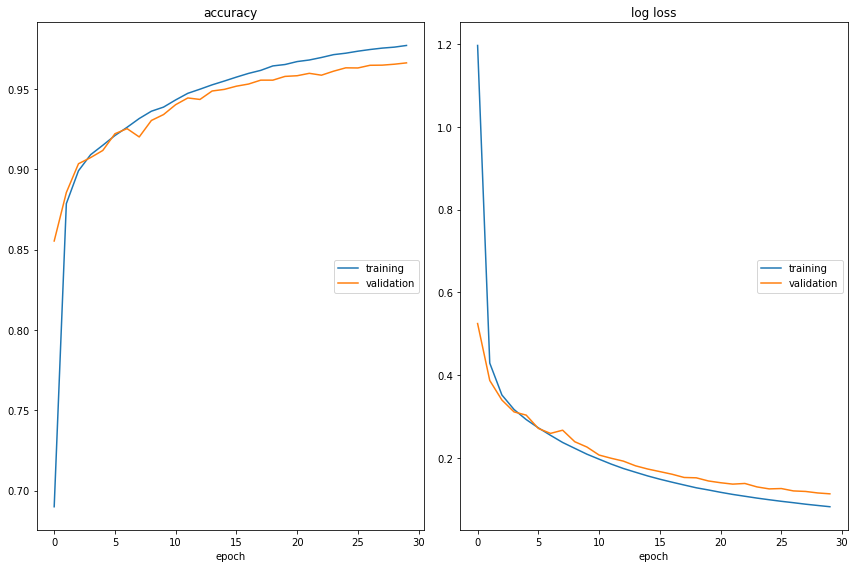

accuracy
	training         	 (min:    0.690, max:    0.977, cur:    0.977)
	validation       	 (min:    0.855, max:    0.966, cur:    0.966)
log loss
	training         	 (min:    0.081, max:    1.197, cur:    0.081)
	validation       	 (min:    0.113, max:    0.525, cur:    0.113)


In [13]:
train_model(pytorch_net, criterion, optimizer, dataloaders, nb_epoch)

In [15]:
torch.save(pytorch_net, 'pytorch_net.pt')

In [16]:
def test_model(model, criterion, test_loader):
    model = model.to(device)
    test_loss = 0.0
    test_corrects = 0

    with torch.no_grad(): # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
         
            _, preds = torch.max(outputs, 1)
        
            test_loss += loss * inputs.size(0) # multiply mean loss by the number of elements
            test_corrects += torch.sum(preds == labels.data) # add number of correct predictions to total
    
        avg_loss = test_loss / len(test_loader.dataset) # get the "mean" loss for the epoch
        avg_acc = test_corrects.float() / len(test_loader.dataset) # Get proportion of correct predictions
    
    return avg_loss.item(), avg_acc.item()

In [17]:
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=bs)

In [18]:
pytorch_loss, pytorch_accuracy = test_model(pytorch_net, criterion, testing_loader)

In [19]:
def print_loss_acc(loss, acc):
    print("Loss : {:.6f}".format(loss))
    print("Accuracy : {:.6f}".format(acc))

In [20]:
print_loss_acc(pytorch_loss, pytorch_accuracy)

Loss : 0.106020
Accuracy : 0.968800
